In [1]:
from image_utils import *
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
def get_points_on_line(a, b, c, start, end):
    '''
    line: ay = bx + c
    returns a list of coordinate tuples
    '''
    line = []
    if a == 0:
        x = -c
        for y in range(start[1], end[1]):
            line.append((x, y))
        return line
    for x in range(start[0], end[0]):
        y = int(round(b * x + c))
        line.append((x, y))
    return line

In [3]:
def get_weight(p1, p2):
    '''
    returns weights of a line of which p1 and p2 are endpoints
    line: ay = bx + c
    '''
    if p1[0] == p2[0]:
        a = 0
        b = 1
        c = -p1[0]
    else:
        a = 1
        b = (p1[1] - p2[1]) / (p1[0] - p2[0])
        c = p2[1] - b * p2[0]
    return a, b, c

In [4]:
def find_major_axis(edge_loc_tuples, center):
    major_axis_endpoints = None
    major_axis_length_sq = -1
    major_axis_a, major_axis_b, major_axis_c = None, None, None
    for p in edge_loc_tuples:
        a, b, c = get_weight(p, center)          
        line = get_points_on_line(a, b, c, (0, 0), (512, 512))
        endpoints = list(set(edge_loc_tuples).intersection(set(line)))
        if len(endpoints) < 2:
            continue
        endpoints.sort()
        if len(endpoints) > 2:
            endpoints = [endpoints[0], endpoints[-1]]
        axis_length_sq = (endpoints[0][0] - endpoints[1][0])**2 + (endpoints[0][1] - endpoints[1][1])**2
        if axis_length_sq > major_axis_length_sq:
            major_axis_endpoints = endpoints
            major_axis_length_sq = axis_length_sq
            major_axis_a, major_axis_b, major_axis_c = a, b, c
            
    return major_axis_endpoints, major_axis_length_sq, major_axis_a, major_axis_b, major_axis_c

In [5]:
def rotate_line(line, center, rd):
    line.sort()
    start, end = line[0], line[-1]
    rotated_points = [rotate_point(center, start, rd), rotate_point(center, end, rd)]
    rotated_points.sort()
    start, end = rotated_points[0], rotated_points[1]
    a, b, c = get_weight(start, end)
    return get_points_on_line(a, b, c, point_to_integer(start), point_to_integer(end))

In [6]:
def find_interpolation_args(center, edge_loc_tuples, half_axis):
    points = [major_axis_endpoints[1]]
    for i in range(1, 8):
        rd = i * 45
        point_tmp = []
        while len(point_tmp) < 1:
            rotated_line = rotate_line(half_axis, center, rd)
            point_tmp = list(set(edge_loc_tuples).intersection(set(rotated_line)))
            rd += .1
        if len(point_tmp) > 1:
            point_tmp.sort(key=lambda p: math.sqrt((p[0] - center[0])**2 + (p[1] - center[1])**2))
        points.append(point_tmp[-1])
    args = []
    for p in points:
        args.append(np.asarray(p))
    args.append(args[0])
    return np.asarray(args)

In [7]:
def plot_points(edge_loc, interpolation_args, center):
    x, y = list(edge_loc[:,0]),list(edge_loc[:,1])
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    ax.plot(x, y, 'ro', label='edges', zorder=1)
    ax.plot(center[0], center[1], 'bo', label='edges', zorder=1)
    for i in range(8):
        x, y = interpolation_args[i,0], interpolation_args[i,1]
        ax.plot(x, y, 'bo', label='edges', zorder=1)
    plt.show()

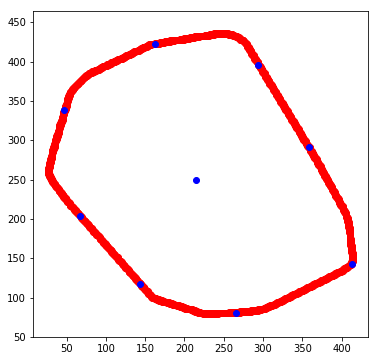

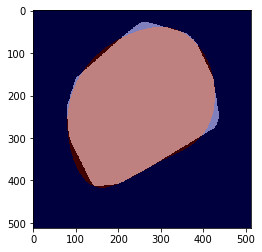

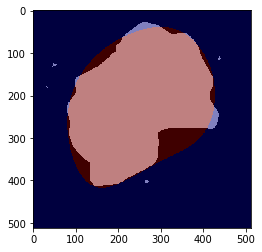

In [11]:
# visualization

image = load_image('example.png')
# cleaned = remove_small_objects(image)
cleaned = leave_biggest_only(image)
chull = find_convexhull(cleaned)

edge = detect_edge(chull)
edge_loc = np.argwhere(edge > 0)
edge_loc_tuples = [tuple(i) for i in edge_loc]

center = center_of_mass(image)
major_axis_endpoints, _, major_axis_a, major_axis_b, major_axis_c = find_major_axis(edge_loc_tuples, center)
half_axis = get_points_on_line(major_axis_a, major_axis_b, major_axis_c, center, (512, 512))

interpolation_args = find_interpolation_args(center, edge_loc_tuples, half_axis)
spline_x, spline_y = spline_interpolate(interpolation_args)
new_image = floodfill_image(spline_x, spline_y, center, 255)

plot_points(edge_loc, interpolation_args, center)
plt.figure()
overlap_image(chull, new_image)
plt.figure()
overlap_image(image, new_image)